## Multivariate Time Series Analysis



In [1]:
from IPython.display import display, Markdown
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

In [1]:
!pip install orbit-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 474 kB 4.0 MB/s 
     |████████████████████████████████| 722 kB 59.9 MB/s 
     |████████████████████████████████| 67.3 MB 94 kB/s 
     |████████████████████████████████| 11.2 MB 39.7 MB/s 
     |████████████████████████████████| 965 kB 52.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
from orbit.models import ETS, DLT
from orbit.diagnostics.plot import plot_predicted_data

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

### Import Data

In [4]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}


datas_m_raw = pd.ExcelFile('Manufacturing_filled.xlsx')
datas_s_raw = pd.ExcelFile('Service_filled.xlsx')
datas_m = {}
datas_s = {}
for con in dic_country.keys():
    datas_m[con] = pd.read_excel(datas_m_raw, sheet_name=con)
    datas_m[con]['Year'] = datas_m[con]['Year'].astype('int')
    datas_s[con] = pd.read_excel(datas_s_raw, sheet_name=con)
    datas_s[con]['Year'] = datas_s[con]['Year'].astype('int')
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


In [5]:
country = list(dic_country.keys())

### Train-test split

In [6]:
def split_train_test(df, valid_num = 5):
    train = df[:-valid_num]
    valid = df[-valid_num:]
    return train, valid

train_manu = {}
valid_manu = {}
train_ser = {}
valid_ser = {}
for con in country:
    train_manu[con], valid_manu[con]= split_train_test(datas_m[con])
    train_ser[con], valid_ser[con]= split_train_test(datas_s[con])

###  Exponential Smoothing (ETS)

#### Maximum a Posteriori (MAP)¶

In [7]:
forecast_manu = {}
forecast_ser = {}
def fitting_ETS(con, response_col, date_col, result, train, test, seasonality = 5,estimator = 'stan-map'):
  ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator= estimator,
    # seasonality=seasonality,
    seed=8888,
  )
  ets.fit(df=train[con])
  predicted_df = ets.predict(df=test[con])
  result[con] = predicted_df

In [8]:
response_col = 'Manufacturing_value added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_ETS(con, response_col, date_col, forecast_manu, train_manu, valid_manu )

response_col = 'Services_value_added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_ETS(con, response_col, date_col, forecast_ser,train_ser, valid_ser)

In [9]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

In [10]:
m_metrics = {}
s_metrics = {}
for con in country:
  if len(train_manu[con].columns) > 1 and 'Manufacturing_value added_%_of_GDP' in valid_manu[con].columns:
    y = valid_manu[con]['Manufacturing_value added_%_of_GDP']
    yhat = forecast_manu[con]['prediction']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval =  [mae,rmse,mape]
    #print(mae, mse, rmse, con)
    m_metrics[con] = eval
  elif len(train_manu[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[(con,m)] = [np.nan,np.nan,np.nan]
  else:
    print(f'Target variable for manufaturce {con} is non-stationary.')
    m_metrics[con] = [np.nan,np.nan,np.nan]

  if  len(train_ser[con].columns) > 1 and 'Services_value_added_%_of_GDP' in valid_ser[con].columns:
    y = valid_ser[con]['Services_value_added_%_of_GDP']
    yhat = forecast_ser[con]['prediction']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
    s_metrics[con] = eval
  elif len(train_ser[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[con] = [np.nan,np.nan,np.nan]
  else:
     print(f'Target variable for service {con}is non-stationary.')
     s_metrics[con] = [np.nan,np.nan,np.nan]

In [35]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']

m_eval

,MAE,RMSE,MAPE
AUS,0.403926,0.414115,0.071370
BRA,0.608208,0.753682,0.061804
CAN,0.252489,0.274816,0.025653
CHN,0.795722,1.030792,0.029774
GBR,0.167354,0.188705,0.019057
IND,0.936837,1.125207,0.067893
JPN,0.267772,0.304826,0.013252
SGP,2.448069,2.606999,0.120876
USA,0.446287,0.454971,0.039855


In [11]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

,MAE,RMSE,MAPE
AUS,1.828189,1.883519,0.027603
BRA,1.010412,1.738804,0.016789
CAN,1.716064,1.904473,0.025519
CHN,1.236163,1.404015,0.022913
GBR,0.565637,0.804392,0.007844
IND,0.773075,1.140966,0.015645
JPN,0.284643,0.303346,0.004097
SGP,0.764876,0.884622,0.010894
USA,0.968015,1.568313,0.012213


#### MCMC - Full Bayesian Sampling¶

In [12]:
response_col = 'Manufacturing_value added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_ETS(con, response_col, date_col, forecast_manu, train_manu, valid_manu,5, 'stan-mcmc')

response_col = 'Services_value_added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_ETS(con, response_col, date_col, forecast_ser,train_ser, valid_ser,5 ,'stan-mcmc')

In [13]:
m_metrics = {}
s_metrics = {}
for con in country:
  if len(train_manu[con].columns) > 1 and 'Manufacturing_value added_%_of_GDP' in valid_manu[con].columns:
    y = valid_manu[con]['Manufacturing_value added_%_of_GDP']
    yhat = forecast_manu[con]['prediction']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval =  [mae,rmse,mape]
    #print(mae, mse, rmse, con)
    m_metrics[con] = eval
  elif len(train_manu[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[con] = [np.nan,np.nan,np.nan]
  else:
    print(f'Target variable for manufaturce {con} is non-stationary.')
    m_metrics[con] = [np.nan,np.nan,np.nan]

  if  len(train_ser[con].columns) > 1 and 'Services_value_added_%_of_GDP' in valid_ser[con].columns:
    y = valid_ser[con]['Services_value_added_%_of_GDP']
    yhat = forecast_ser[con]['prediction']
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = sqrt(mean_squared_error(y, yhat))
    eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
    s_metrics[con] = eval
  elif len(train_ser[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[con] = [np.nan,np.nan,np.nan]
  else:
     print(f'Target variable for service {con}is non-stationary.')
     s_metrics[con] = [np.nan,np.nan,np.nan]

In [14]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']

m_eval

,MAE,RMSE,MAPE
AUS,0.435871,0.455018,0.077077
BRA,0.799052,0.912611,0.080467
CAN,0.187334,0.235803,0.018992
CHN,1.027950,1.231088,0.038306
GBR,0.211469,0.226436,0.024021
IND,1.057400,1.225233,0.076371
JPN,0.303911,0.324366,0.014958
SGP,2.271355,2.431776,0.112069
USA,0.476224,0.496754,0.042553


In [15]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

,MAE,RMSE,MAPE
AUS,1.684221,1.754009,0.025437
BRA,1.176198,1.868013,0.019467
CAN,1.748684,1.985079,0.025984
CHN,1.233062,1.441011,0.022837
GBR,0.601811,0.846980,0.008351
IND,0.798373,1.127706,0.016186
JPN,0.403019,0.442020,0.005801
SGP,0.763684,0.910472,0.010909
USA,1.006878,1.544071,0.012727


### Damped Local Trend (DLT)

#### Linear trends

In [16]:
train_ser["AUS"]

,Year,Net_trade_in_goods_services,Foreign_direct_investment,Mobile_cellular_subscriptions,School_enrollment_tertiary,Population_labor_rate,Population_density,Unnamed: 9,GDP_per_capita_current_USD,Final_consumption,Individuals_using_the_Internet_%_of_population,Services_value_added_%_of_GDP
0,1990,-3.259470e+09,2.716689,1.849430e+05,35.359550,66.851833,2.221353,100,18243.471418,2.255137e+11,0.585095,59.500110
1,1991,-1.017165e+09,1.697964,2.416004e+05,36.930784,66.856351,2.236509,100,18569.157896,2.363181e+11,0.857493,61.248745
2,1992,-8.584878e+08,1.630295,3.378179e+05,37.974355,66.828013,2.251881,100,18582.354993,2.429499e+11,1.200799,61.893522
3,1993,-9.945157e+08,1.651794,4.433921e+05,46.245015,66.778427,2.266217,100,18308.013563,2.423600e+11,1.432766,62.559599
4,1994,-1.939462e+09,1.583028,6.407227e+05,51.513430,66.728568,2.280943,100,18249.919428,2.431883e+11,1.635872,62.525663
5,1995,-2.679042e+09,2.036385,9.994881e+05,55.809610,66.693622,2.296958,100,18722.308528,2.513105e+11,1.887655,62.432973
6,1996,-2.243591e+09,1.854050,1.606366e+06,59.835455,66.665637,2.314526,100,19368.042525,2.618849e+11,2.169245,62.482313
7,1997,-1.514640e+09,1.854779,2.163229e+06,63.784049,66.652999,2.332482,100,20144.108276,2.738706e+11,4.830247,63.437404
8,1998,-2.384183e+09,1.863111,2.646860e+06,63.784049,66.657105,2.350585,100,20355.108954,2.785310e+11,9.391857,63.606197
9,1999,-3.664558e+09,1.647743,3.256947e+06,63.784049,66.672255,2.369380,100,20389.013607,2.815571e+11,14.612975,64.359084


In [17]:

forecast_manu = {}
forecast_ser = {}
def fitting_DLT( con, response_col, date_col, result, train, test, regressor_col = [], seasonality = 5,estimator = 'stan-map',global_trend_option = 'linear'):
  dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seed=8888,
    global_trend_option= global_trend_option,
    regressor_col = regressor_col,
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)
  dlt.fit(df=train[con])
  predicted_df = dlt.predict(df=test[con])
  result[con] = predicted_df



In [18]:
response_col = 'Manufacturing_value added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_DLT(con, response_col, date_col, forecast_manu, train_manu, valid_manu)

response_col = 'Services_value_added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_DLT(con, response_col, date_col, forecast_ser,train_ser, valid_ser,['Foreign_direct_investment'])

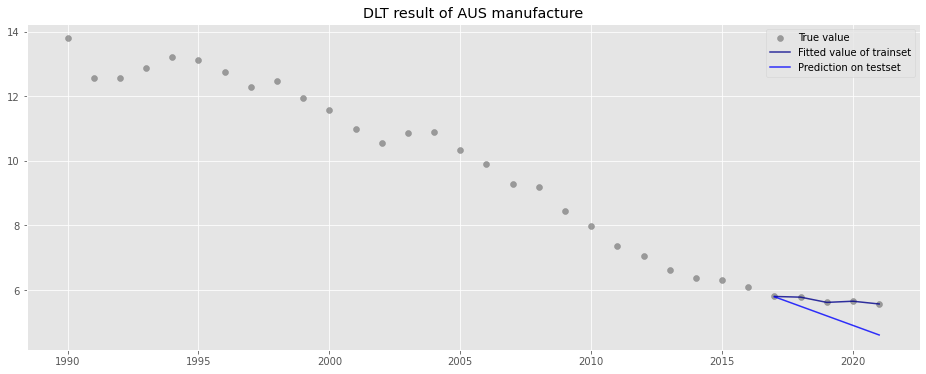

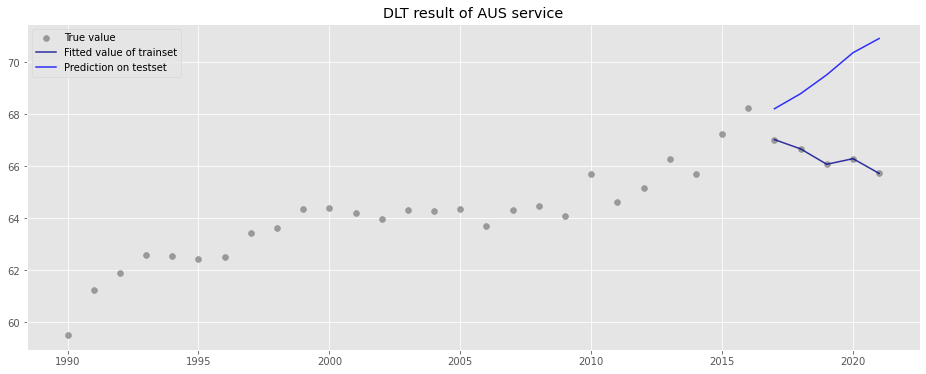

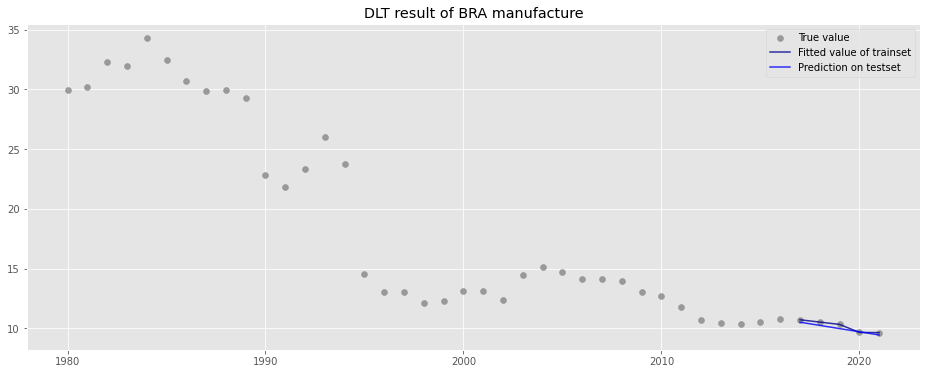

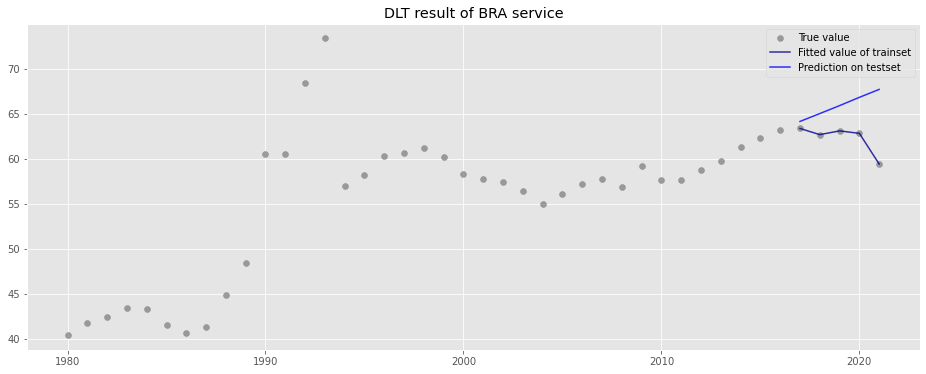

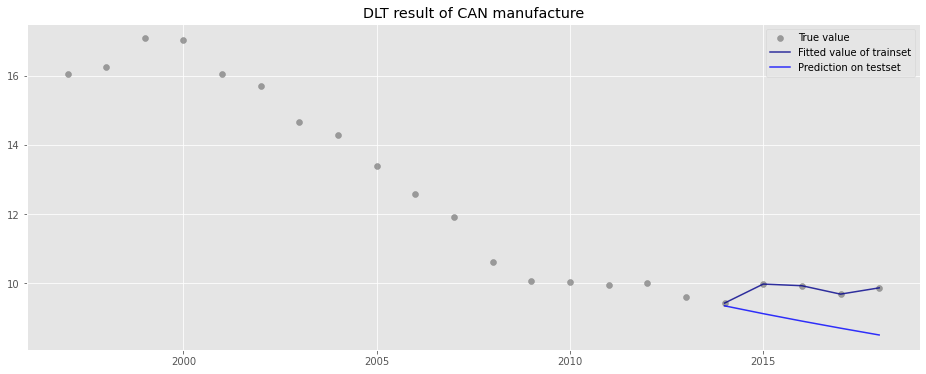

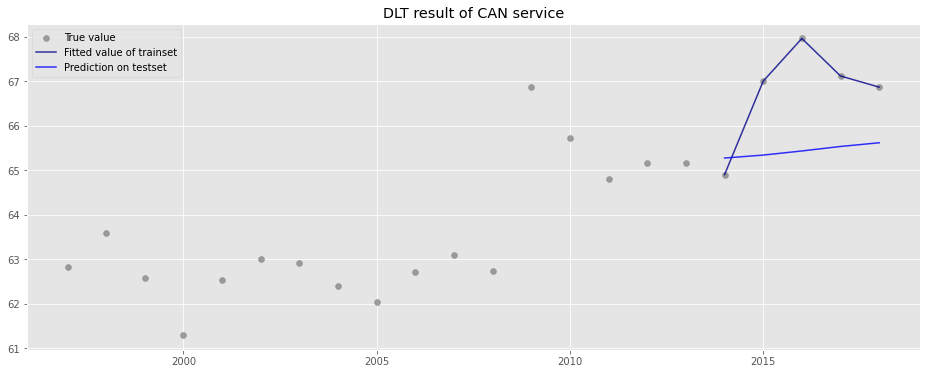

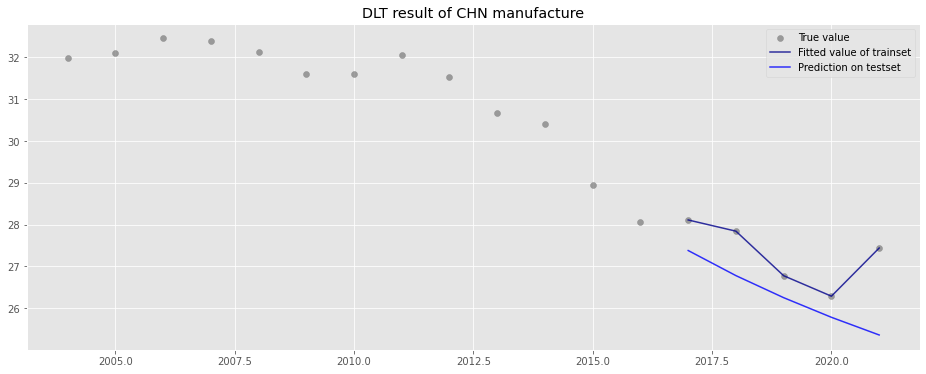

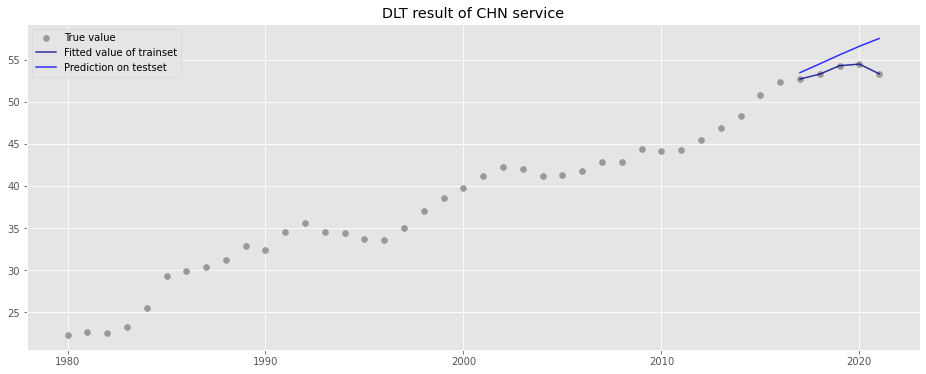

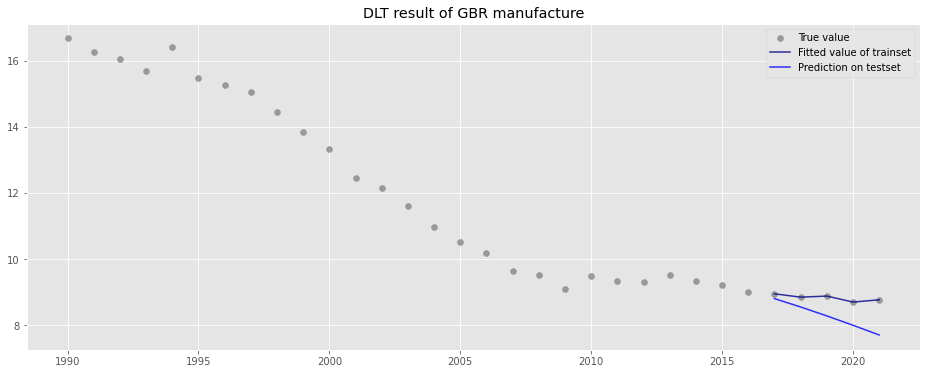

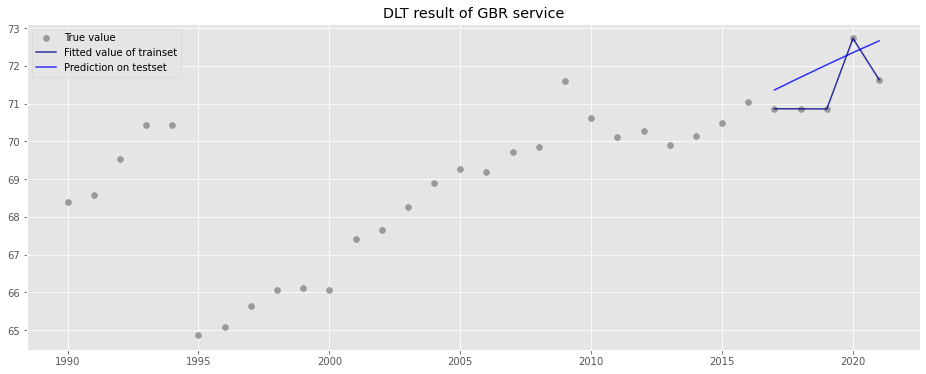

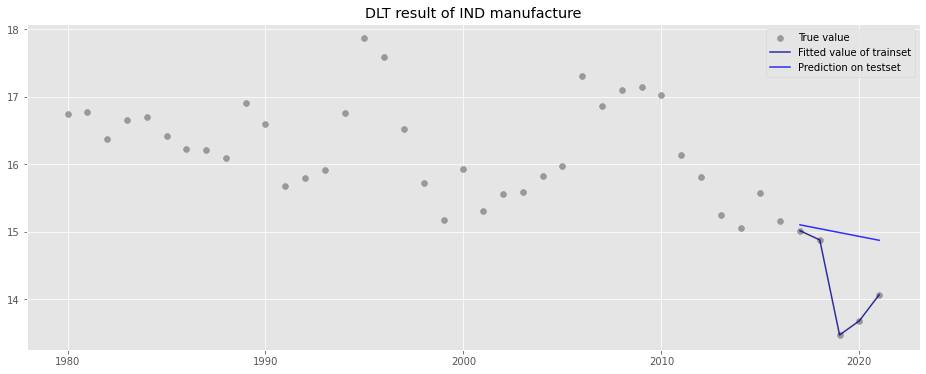

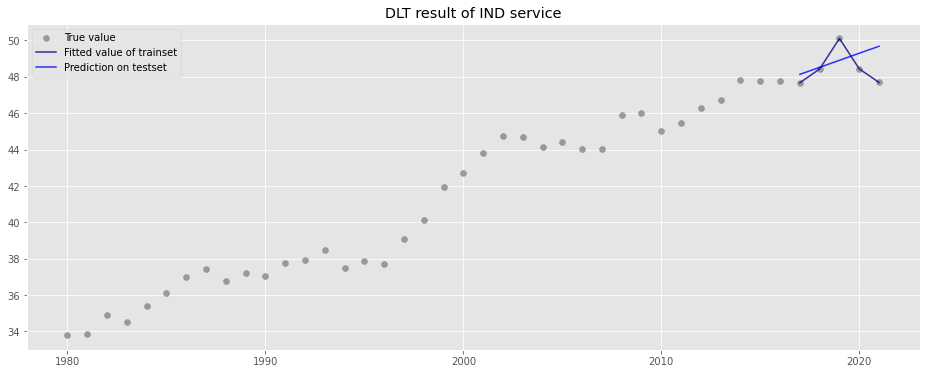

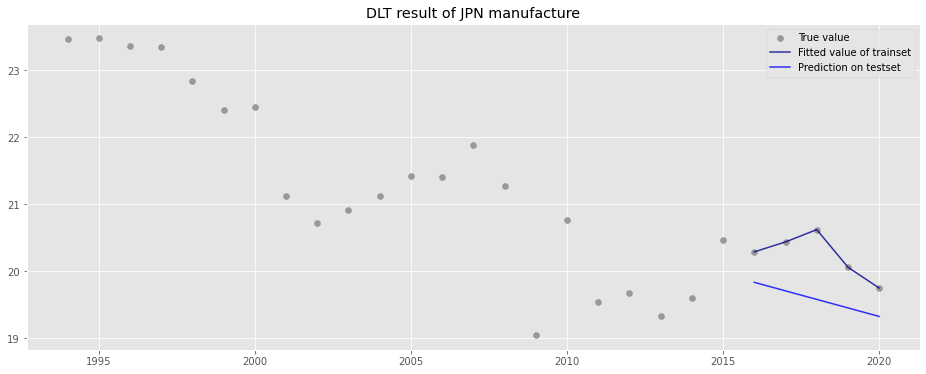

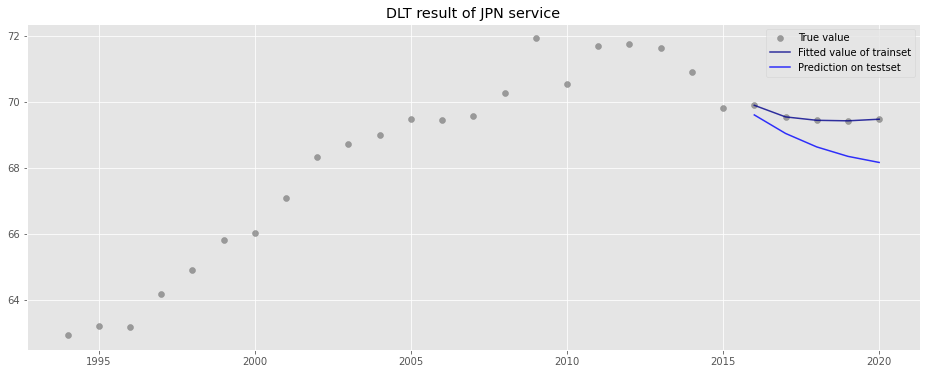

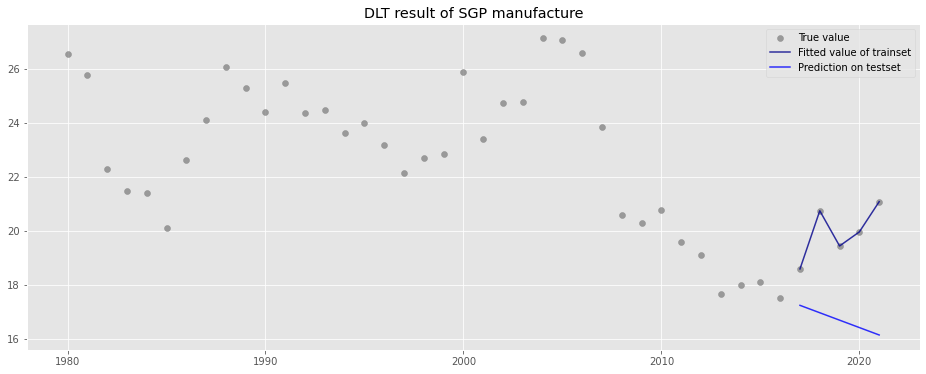

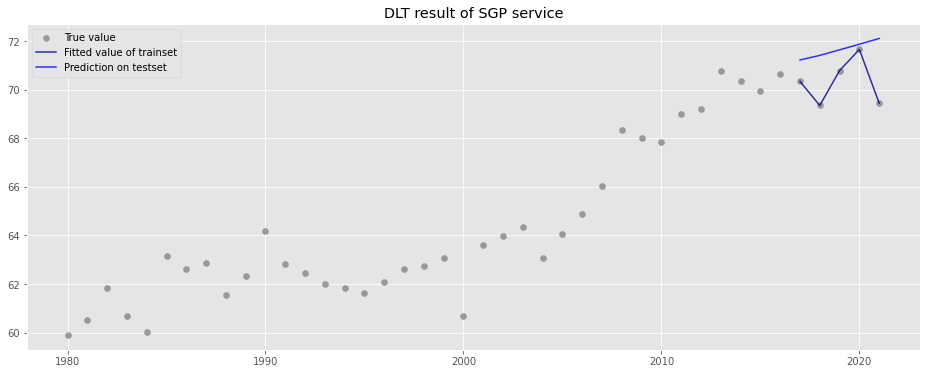

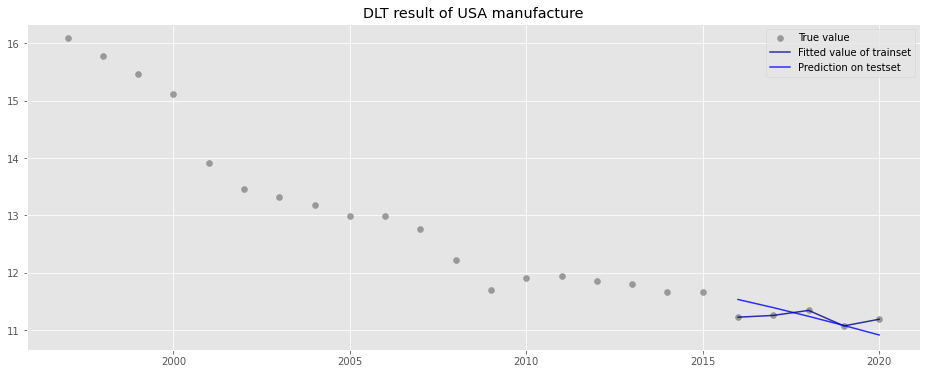

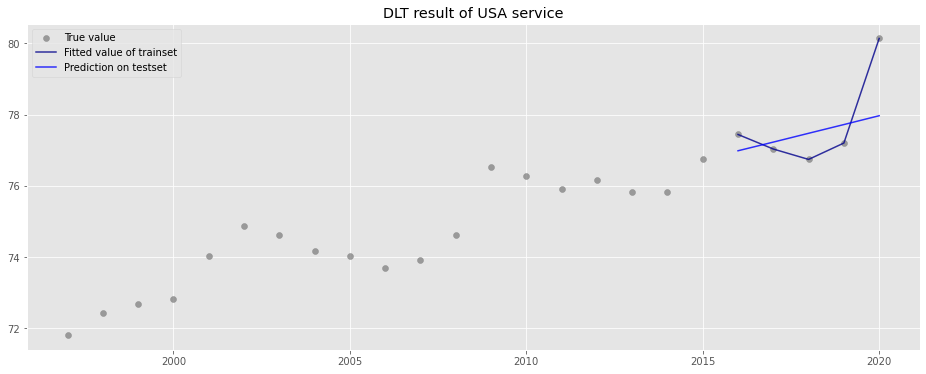

In [37]:
m_metrics = {}
s_metrics = {}
for con in country:
  if len(train_manu[con].columns) > 1 and 'Manufacturing_value added_%_of_GDP' in valid_manu[con].columns:
    y = valid_manu[con]['Manufacturing_value added_%_of_GDP']
    yhat = forecast_manu[con]['prediction']
    plt.figure(figsize=(16, 6))
    plt.scatter(datas_m[con]['Year'], datas_m[con]['Manufacturing_value added_%_of_GDP'], label='True value', color='gray', alpha=0.75)
    plt.plot(forecast_manu[con]['Year'], y, label='Fitted value of trainset', color='darkblue', alpha=0.8)
    plt.plot(forecast_manu[con]['Year'], yhat, label='Prediction on testset', color='blue', alpha=0.8)
    plt.legend()
    plt.title(f'DLT result of {con} manufacture')
    plt.show()
    mae = round(mean_absolute_error(y, yhat),4)
    mape = round(mean_absolute_percentage_error(y, yhat),4)
    rmse = round(sqrt(mean_squared_error(y, yhat)),4)
    eval =  [mae,rmse,mape]
    #print(mae, mse, rmse, con)
    m_metrics[con] = eval
  elif len(train_manu[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[con] = [np.nan,np.nan,np.nan]
  else:
    print(f'Target variable for manufaturce {con} is non-stationary.')
    m_metrics[con] = [np.nan,np.nan,np.nan]

  if  len(train_ser[con].columns) > 1 and 'Services_value_added_%_of_GDP' in valid_ser[con].columns:
    y = valid_ser[con]['Services_value_added_%_of_GDP']
    yhat = forecast_ser[con]['prediction']
    plt.figure(figsize=(16, 6))
    plt.scatter(datas_s[con]['Year'], datas_s[con]['Services_value_added_%_of_GDP'], label='True value', color='gray', alpha=0.75)
    plt.plot(forecast_ser[con]['Year'], y, label='Fitted value of trainset', color='darkblue', alpha=0.8)
    plt.plot(forecast_ser[con]['Year'], yhat, label='Prediction on testset', color='blue', alpha=0.8)
    plt.legend()
    plt.title(f'DLT result of {con} service')
    plt.show()
    mae = round(mean_absolute_error(y, yhat),4)
    mape = round(mean_absolute_percentage_error(y, yhat),4)
    rmse = round(sqrt(mean_squared_error(y, yhat)),4)
    eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
    s_metrics[con] = eval
  elif len(train_ser[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[con] = [np.nan,np.nan,np.nan]
  else:
     print(f'Target variable for service {con}is non-stationary.')
     s_metrics[con] = [np.nan,np.nan,np.nan]

In [113]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']

m_eval.round(4)

,MAE,RMSE,MAPE
AUS,0.4842,0.5898,0.0861
BRA,0.2156,0.2371,0.0210
CAN,0.8607,0.9599,0.0874
CHN,0.9813,1.1426,0.0358
GBR,0.5610,0.6465,0.0638
IND,0.7653,0.9539,0.0556
JPN,0.6514,0.6888,0.0321
SGP,3.2713,3.4808,0.1616
USA,0.1661,0.2000,0.0148


In [120]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

,MAE,RMSE,MAPE
AUS,3.2033,3.5015,0.0484
BRA,3.6450,4.4454,0.0595
CAN,1.4783,1.6337,0.0220
CHN,1.9153,2.2707,0.0357
GBR,0.7811,0.8381,0.0110
IND,0.9201,1.1274,0.0190
JPN,0.7966,0.8783,0.0115
SGP,1.3365,1.6079,0.0192
USA,0.8147,1.0734,0.0104


### Local Global Trend (LGT)

In [121]:
from orbit.models import LGT

In [122]:

forecast_manu = {}
forecast_ser = {}
def fitting_LGT(con, response_col, date_col, result, train, test, seasonality = 5,estimator = 'stan-map'):
  lgt = LGT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-map',
    seed=8888,
)
  lgt.fit(df=train[con])
  predicted_df = lgt.predict(df=test[con])
  result[con] = predicted_df



In [123]:
response_col = 'Manufacturing_value added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_DLT(con, response_col, date_col, forecast_manu, train_manu, valid_manu)

response_col = 'Services_value_added_%_of_GDP'
date_col = 'Year'
for con in country:
  fitting_DLT( con, response_col, date_col, forecast_ser,train_ser, valid_ser)

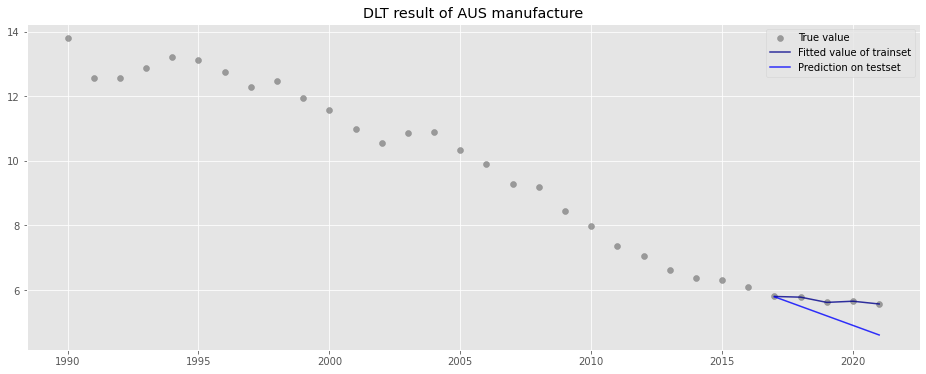

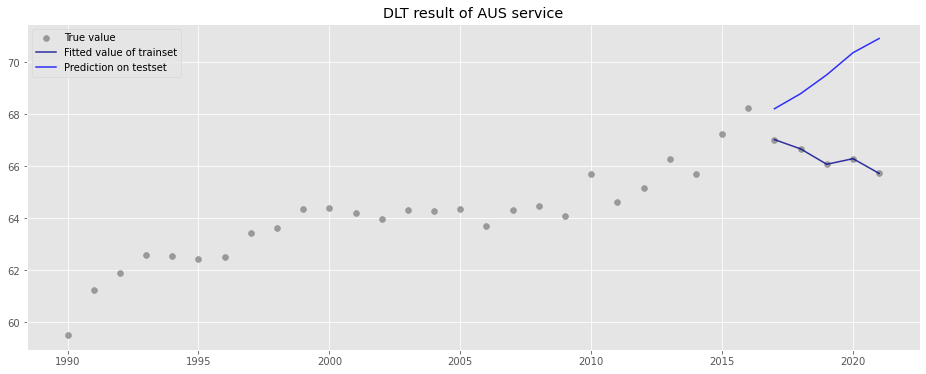

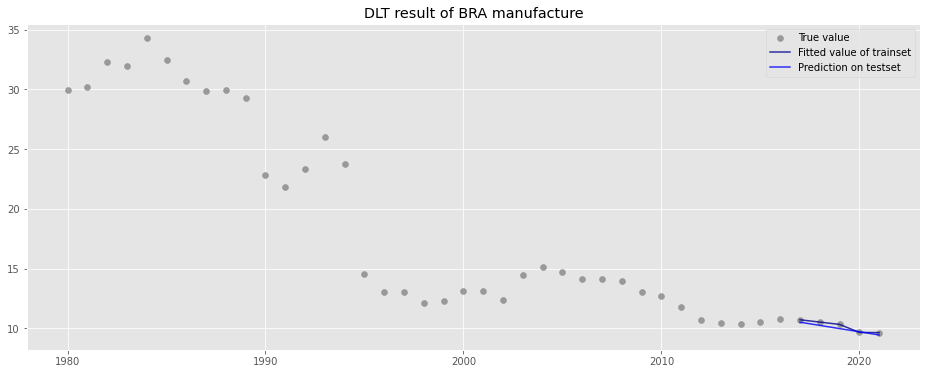

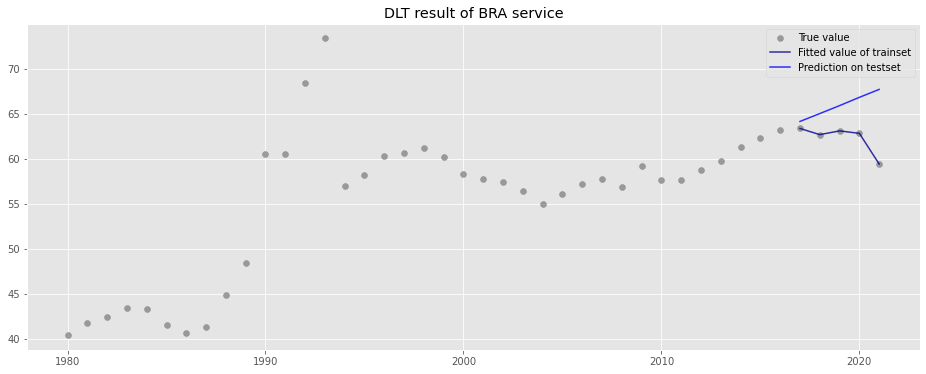

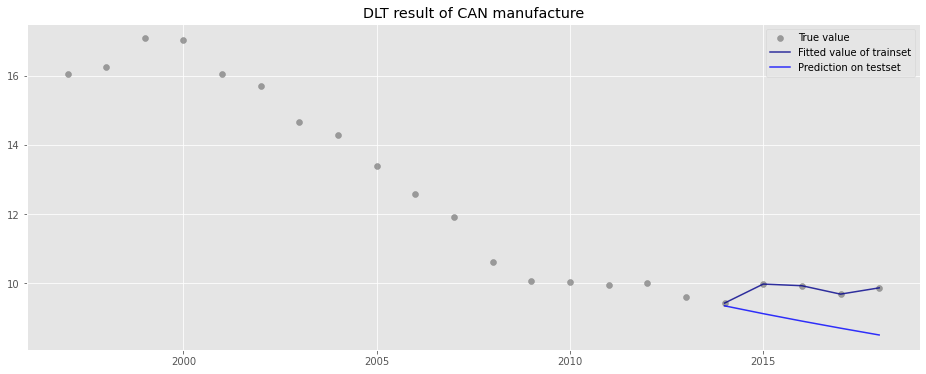

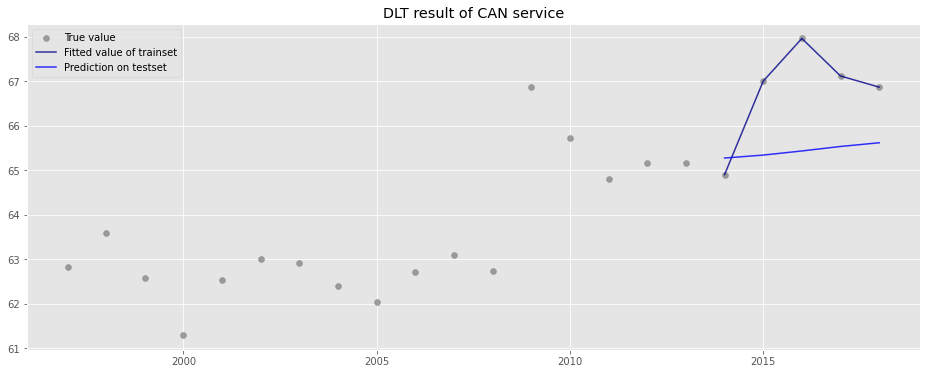

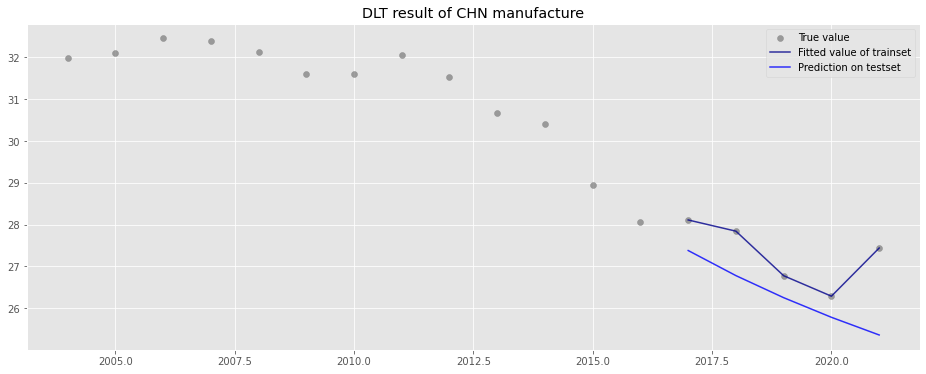

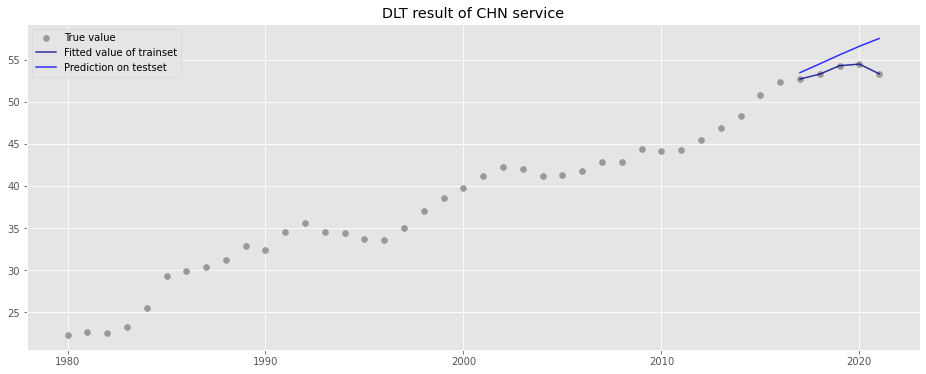

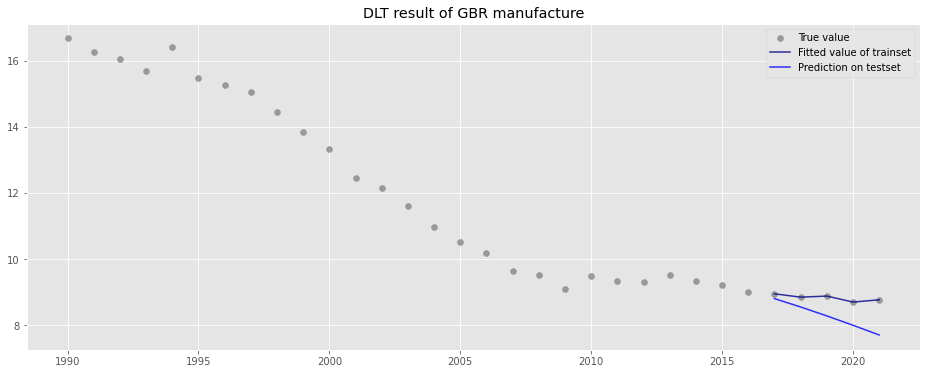

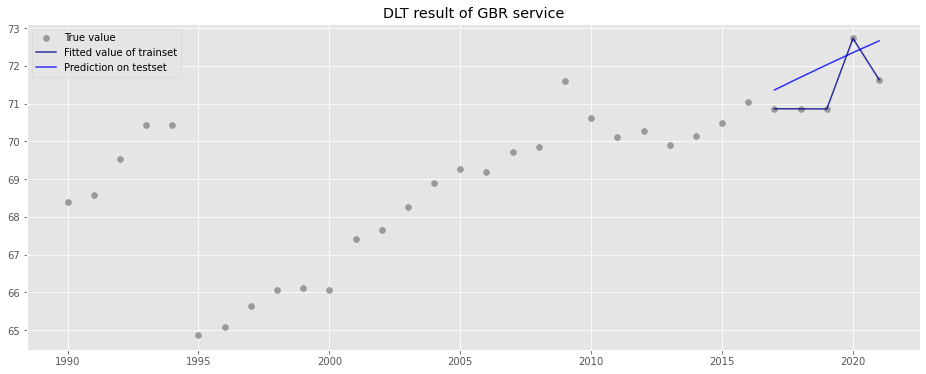

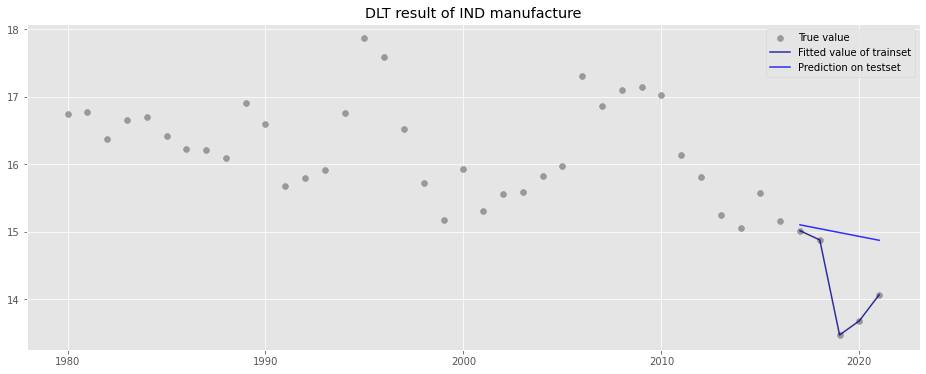

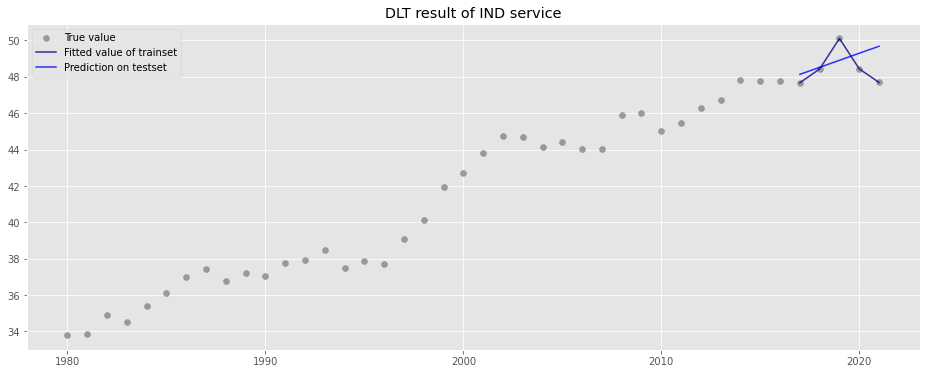

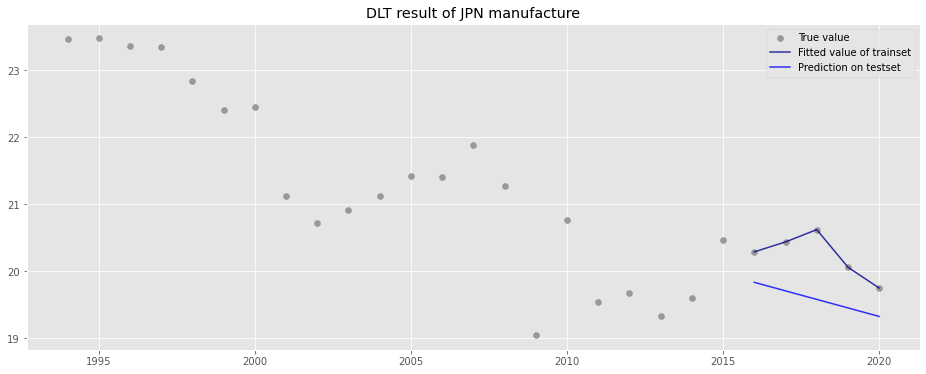

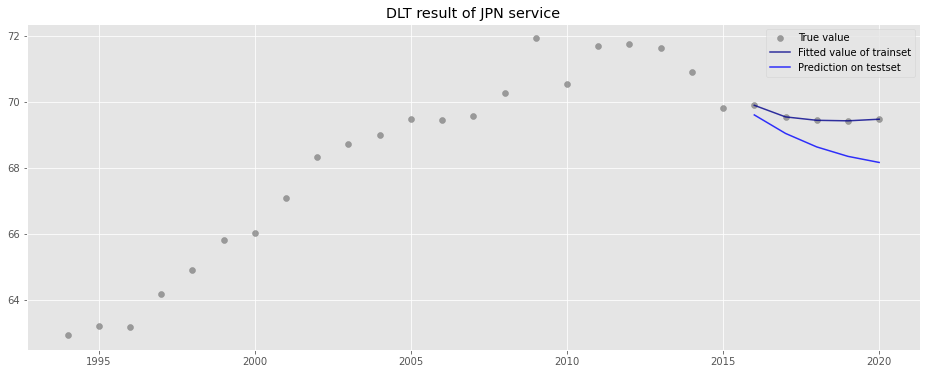

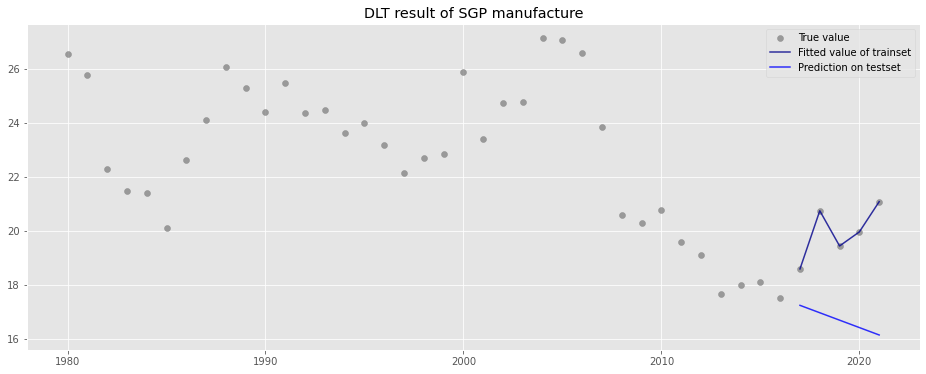

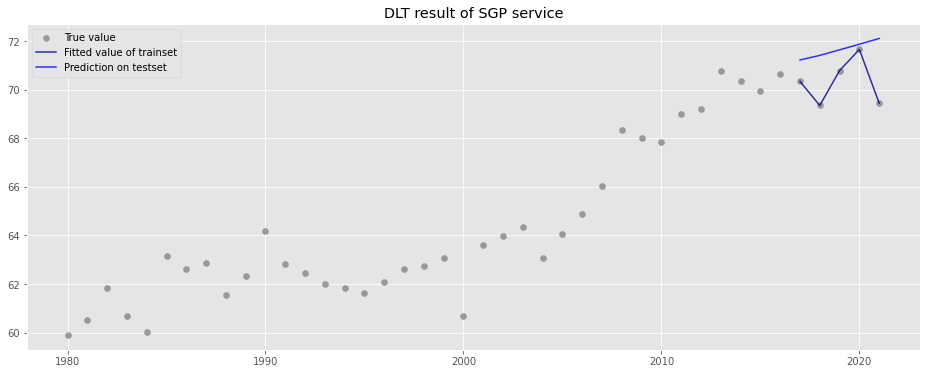

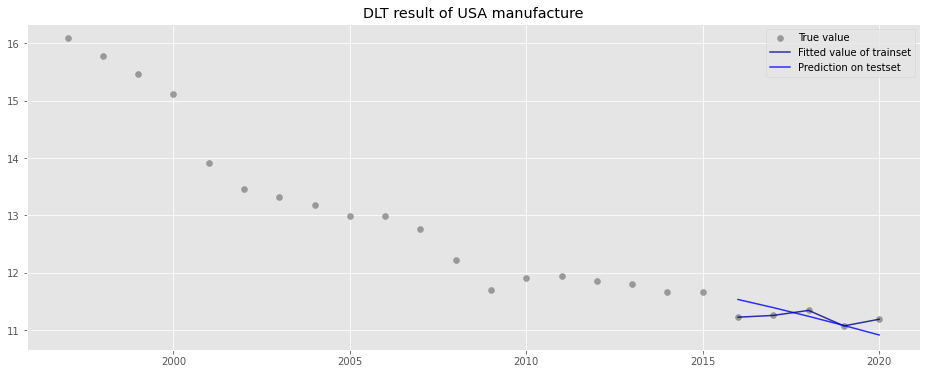

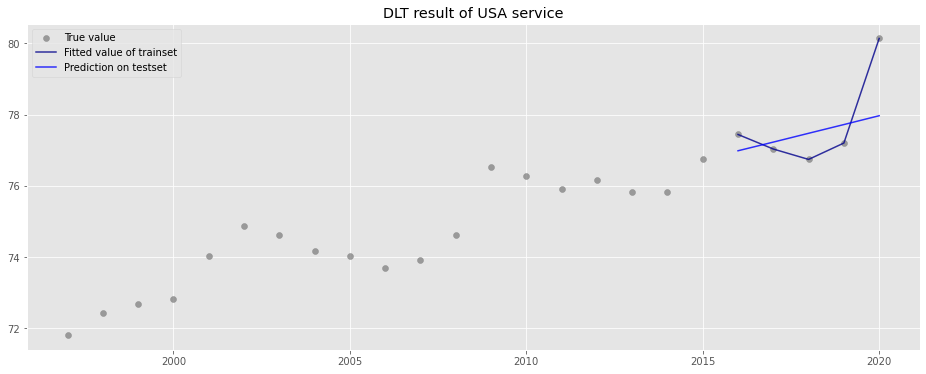

In [40]:
m_metrics = {}
s_metrics = {}
for con in country:
  if len(train_manu[con].columns) > 1 and 'Manufacturing_value added_%_of_GDP' in valid_manu[con].columns:
    y = valid_manu[con]['Manufacturing_value added_%_of_GDP']
    yhat = forecast_manu[con]['prediction']
    plt.figure(figsize=(16, 6))
    plt.scatter(datas_m[con]['Year'], datas_m[con]['Manufacturing_value added_%_of_GDP'], label='True value', color='gray', alpha=0.75)
    plt.plot(forecast_manu[con]['Year'], y, label='Fitted value of trainset', color='darkblue', alpha=0.8)
    plt.plot(forecast_manu[con]['Year'], yhat, label='Prediction on testset', color='blue', alpha=0.8)
    plt.legend()
    plt.title(f'DLT result of {con} manufacture')
    plt.show()
    mae = round(mean_absolute_error(y, yhat),4)
    mape = round(mean_absolute_percentage_error(y, yhat),4)
    rmse = round(sqrt(mean_squared_error(y, yhat)),4)
    eval =  [mae,rmse,mape]
    #print(mae, mse, rmse, con)
    m_metrics[con] = eval
  elif len(train_manu[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[con] = [np.nan,np.nan,np.nan]
  else:
    print(f'Target variable for manufaturce {con} is non-stationary.')
    m_metrics[con] = [np.nan,np.nan,np.nan]

  if  len(train_ser[con].columns) > 1 and 'Services_value_added_%_of_GDP' in valid_ser[con].columns:
    y = valid_ser[con]['Services_value_added_%_of_GDP']
    yhat = forecast_ser[con]['prediction']
    plt.figure(figsize=(16, 6))
    plt.scatter(datas_s[con]['Year'], datas_s[con]['Services_value_added_%_of_GDP'], label='True value', color='gray', alpha=0.75)
    plt.plot(forecast_ser[con]['Year'], y, label='Fitted value of trainset', color='darkblue', alpha=0.8)
    plt.plot(forecast_ser[con]['Year'], yhat, label='Prediction on testset', color='blue', alpha=0.8)
    plt.legend()
    plt.title(f'DLT result of {con} service')
    plt.show()
    mae = round(mean_absolute_error(y, yhat),4)
    mape = round(mean_absolute_percentage_error(y, yhat),4)
    rmse = round(sqrt(mean_squared_error(y, yhat)),4)
    eval = [mae,rmse,mape]
      #print(mae, mse, rmse, con)
    s_metrics[con] = eval
  elif len(train_ser[con].columns) == 1:
    print(f'Only contains target variable for service {con}.')
    s_metrics[con] = [np.nan,np.nan,np.nan]
  else:
     print(f'Target variable for service {con}is non-stationary.')
     s_metrics[con] = [np.nan,np.nan,np.nan]

In [38]:
m_eval = pd.DataFrame(m_metrics).transpose()
m_eval.columns = ['MAE', 'RMSE','MAPE']

m_eval

,MAE,RMSE,MAPE
AUS,0.4842,0.5898,0.0861
BRA,0.2156,0.2371,0.0210
CAN,0.8607,0.9599,0.0874
CHN,0.9813,1.1426,0.0358
GBR,0.5610,0.6465,0.0638
IND,0.7653,0.9539,0.0556
JPN,0.6514,0.6888,0.0321
SGP,3.2713,3.4808,0.1616
USA,0.1661,0.2000,0.0148


In [39]:
s_eval = pd.DataFrame(s_metrics).transpose()
s_eval.columns = ['MAE','RMSE','MAPE']
s_eval

,MAE,RMSE,MAPE
AUS,3.2033,3.5015,0.0484
BRA,3.6450,4.4454,0.0595
CAN,1.4783,1.6337,0.0220
CHN,1.9153,2.2707,0.0357
GBR,0.7811,0.8381,0.0110
IND,0.9201,1.1274,0.0190
JPN,0.7966,0.8783,0.0115
SGP,1.3365,1.6079,0.0192
USA,0.8147,1.0734,0.0104
